В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

**Імпортуємо необхідні бібліотеки:**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

Area under ROC score on Train dataset: 0.81%


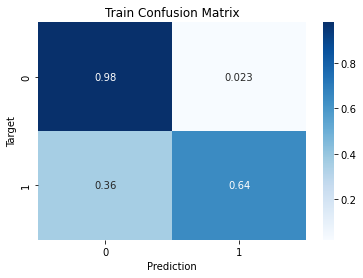

Area under ROC score on Validation dataset: 0.75%


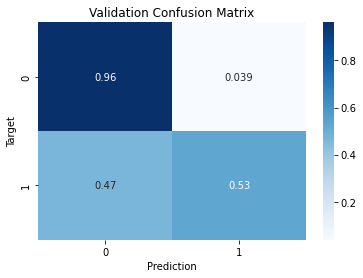

['HW_2.8.joblib']

In [4]:
start_test_df = pd.read_csv('test.csv') # завантажуємо тестовий набір даних
start_train_df = pd.read_csv('train.csv') # завантажуємо трейновий набір даних

#Оскільки подальшу роботу ми будемо вести використовучи id клієнта, то колонку Surname і CustomerId видалимо як зайві і ту, що не несут інформаційного навантаження
columns_to_drop = ['Surname', 'CustomerId']
start_test_df = start_test_df.drop(columns_to_drop, axis=1)
start_train_df = start_train_df.drop(columns_to_drop, axis=1)

#id має числовий формат, а це є не логічно і не оптимально з точки зору розміру даних. Змінимо тип даних в колонці на str
start_train_df['id'] = start_train_df['id'].astype("str")
start_test_df['id'] = start_test_df['id'].astype("str")


train_df, val_df = train_test_split(start_train_df, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols =  train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'HW_2.8.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.84%


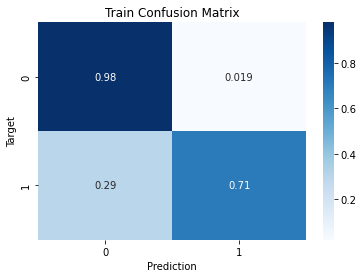

Area under ROC score on Validation dataset: 0.78%


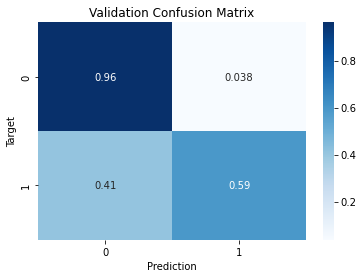

In [6]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

numeric_transformer_2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', poly_features)
])

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

model_pipeline_2 = Pipeline(steps=[
    ('preprocessor_2', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_2.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_2 = predict_and_plot(model_pipeline_2, train_inputs, train_targets, 'Train')
val_preds_2 = predict_and_plot(model_pipeline_2, val_inputs, val_targets, 'Validation')

**Висновок:**
Спостерігаємо покращення результатів моделі при введені поліноміальних ознак. Але спостерігається перенавчання, це ми можемо бачити по більш високому показнику ROC score на трейнових даних ніж на валідаційних

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.87%


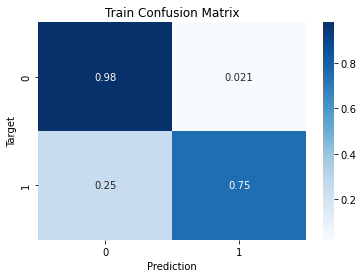

Area under ROC score on Validation dataset: 0.80%


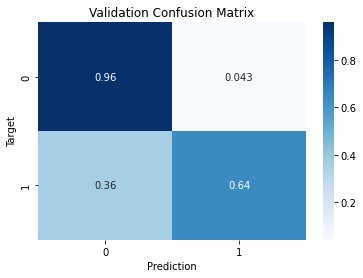

In [9]:
poly_features_2 = PolynomialFeatures(degree=4, include_bias=False)

numeric_transformer_3 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', poly_features_2)
])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_3, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

model_pipeline_3 = Pipeline(steps=[
    ('preprocessor_2', preprocessor_3),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_3.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_3 = predict_and_plot(model_pipeline_3, train_inputs, train_targets, 'Train')
val_preds_3 = predict_and_plot(model_pipeline_3, val_inputs, val_targets, 'Validation')

**Висновок:**
Зі збільшенням поліноміальних ознак ми бачимо, що якість моделі підвищується, але залишається перенавчання.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [12]:
start_df = pd.read_csv('regression_data.csv') # завантажуємо набір даних
start_df.head(5)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [13]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


No handles with labels found to put in legend.


Loss (train): 3.8023122168484003e-13
Loss (test): 16.212257711627707


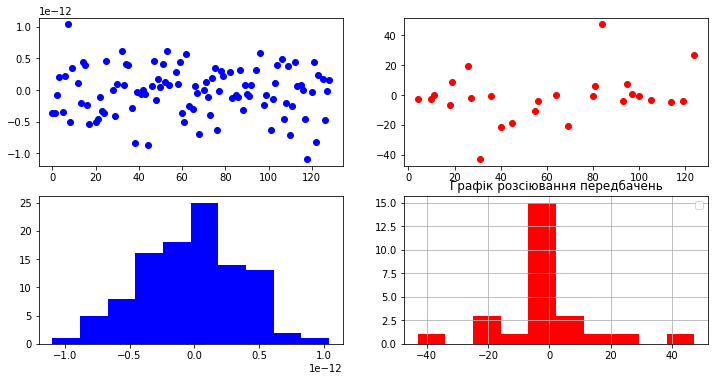

In [14]:
train_df, test_df = train_test_split(start_df, test_size=0.2, random_state=42)

# Створюємо трен. і тест. набори
input_cols = list(train_df.columns)[:-1]
target_col = 'target'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

numeric_cols_inputs = train_inputs.select_dtypes(include=np.number).columns.tolist()

poly_features_4 = PolynomialFeatures(degree=5, include_bias=False)

numeric_transformer_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', poly_features_4)
])

preprocessor_4 = ColumnTransformer(
    transformers=[
        ('num_inputs', numeric_transformer_4, numeric_cols_inputs)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_4 = Pipeline(steps=[
    ('preprocessor_4', preprocessor_4),
    ('classifier', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline_4.fit(train_inputs, train_targets)

# Робимо передбачення моделлю (train)
train_preds = model_pipeline_4.predict(train_inputs)

# Рахуємо лосс (train)
loss_tr = mean_squared_error(train_targets, train_preds, squared=False)
print('Loss (train):', loss_tr)

# Робимо передбачення моделлю (test)
test_preds = model_pipeline_4.predict(test_inputs)

# Рахуємо лосс (test)
loss_te = mean_squared_error(test_targets, test_preds, squared=False)
print('Loss (test):', loss_te)

# Візуалізація результатів
errors_tr = train_targets - train_preds
errors_te = test_targets -  test_preds


plt.figure(figsize=(12, 6))

plt.subplot(2,2,1)
plt.plot(errors_tr,'o', color='blue', label='Errors (train)')

plt.subplot(2,2,2)
plt.plot(errors_te,'o', color='red', label='Errors (test)')

plt.subplot(2,2,3)
plt.hist(errors_tr, color='blue')

plt.subplot(2,2,4)
plt.hist(errors_te, color='red')

plt.title('Графік розсіювання передбачень')
plt.legend()
plt.grid(True)
plt.show()

**Висновок:**
На основі отриманих результатів бачимо, що модель на трейнових даних показала хороші результати і графік розсіювання схожий на нормальне розподілення. А ось на тестових даних ми спостерігаємо значне погіршення результатів. Це свідчить про те, що модель погано розпізнає нові дані. Необхідно працювати далі над даною моделлю.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [17]:
poly_features_5 = PolynomialFeatures(degree=20, include_bias=False)

numeric_transformer_5 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', poly_features_5)
])

preprocessor_5 = ColumnTransformer(
    transformers=[
        ('num_inputs', numeric_transformer_5, numeric_cols_inputs)
    ])

model_pipeline_lasso = Pipeline(steps=[
    ('preprocessor_5', preprocessor_5),
    ('Lasso', Lasso())
])

# Тренуємо пайплайн
model_pipeline_lasso.fit(train_inputs, train_targets)

test_preds_Lasso = model_pipeline_lasso.predict(test_inputs)

loss_tr_Lasso = mean_squared_error(train_targets, model_pipeline_lasso.predict(train_inputs))
loss_te_Lasso = mean_squared_error(test_targets, test_preds_Lasso)

In [18]:
model_pipeline_Ridge = Pipeline(steps=[
    ('preprocessor_5', preprocessor_5),
    ('Ridge', Ridge())
])

# Тренуємо пайплайн
model_pipeline_Ridge.fit(train_inputs, train_targets)

test_preds_Ridge = model_pipeline_Ridge.predict(test_inputs)

loss_tr_Ridge = mean_squared_error(train_targets, model_pipeline_Ridge.predict(train_inputs))
loss_te_Ridge = mean_squared_error(test_targets, test_preds_Ridge)

In [19]:
model_pipeline_ElasticNet = Pipeline(steps=[
    ('preprocessor_5', preprocessor_5),
    ('ElasticNet', ElasticNet())
])

# Тренуємо пайплайн
model_pipeline_ElasticNet.fit(train_inputs, train_targets)

test_preds_ElasticNet = model_pipeline_ElasticNet.predict(test_inputs)

loss_tr_ElasticNet = mean_squared_error(train_targets, model_pipeline_ElasticNet.predict(train_inputs))
loss_te_ElasticNet = mean_squared_error(test_targets, test_preds_ElasticNet)

In [20]:
print('Loss LinearRegression (train):', loss_tr)
print('Loss LinearRegression (test):', loss_te.round(2))
print('Loss Lasso (train):', loss_tr_Lasso.round(2))
print('Loss Lasso (test):', loss_te_Lasso.round(2))
print('Loss Ridge (train):', loss_tr_Ridge.round(2))
print('Loss Ridge (test):', loss_te_Ridge.round(2))
print('Loss ElasticNet (train):', loss_tr_ElasticNet.round(2))
print('Loss ElasticNet (test):', loss_te_ElasticNet.round(2))
input_cols

Loss LinearRegression (train): 3.8023122168484003e-13
Loss LinearRegression (test): 16.21
Loss Lasso (train): 25.99
Loss Lasso (test): 32.17
Loss Ridge (train): 34.63
Loss Ridge (test): 49.3
Loss ElasticNet (train): 902.07
Loss ElasticNet (test): 926.74


['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

**На основі отриманих результатів можемо зробити попередній висновок, що найкраще дані генералізує логістична регресія. Три інші показують вищі втрати. Також на кожній моделі ми бачимо перенавчання і збільшення втрат на тестових даних**

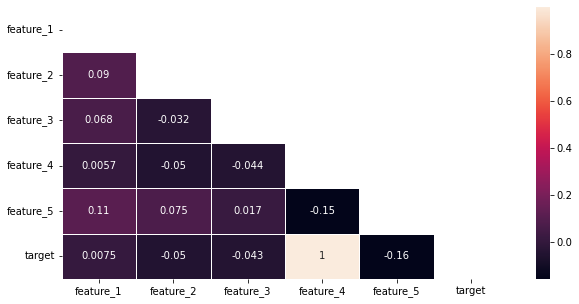

In [22]:
# будуємо матрицю кореляції
cor_df_x = pd.concat([train_inputs, test_inputs], axis=0)
cor_df_y = pd.concat([train_targets, test_targets], axis=0)
cor_df = pd.concat([cor_df_x, cor_df_y], axis=1)
plt.figure(figsize=(10, 5))
matrix = np.triu(cor_df.corr())
sns.heatmap(cor_df.corr(), annot=True, linewidth=.8, mask=matrix, cmap="rocket");

На основі матриці кореляції бачимо, що дані дуже погано корелюють між собою. Єдина корелюча ознака, `feature_4`, є прямопропорційною.

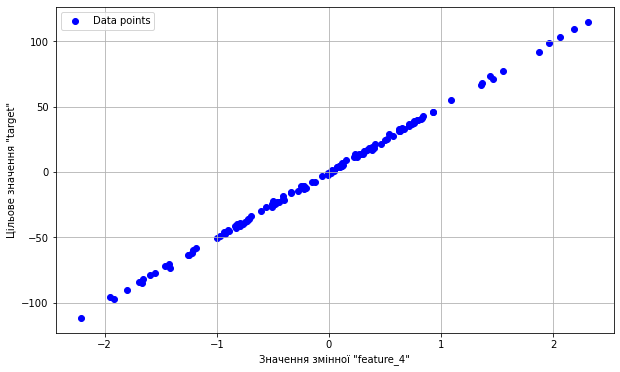

In [24]:
# Візуалізація 'target' і 'feature_4'

plt.figure(figsize=(10, 6))
plt.scatter(start_df['feature_4'], start_df['target'], color='blue', label='Data points')
#plt.plot(X_smoker, predictions_sklearn_smoker, color='orange', label='Scikit-learn')
plt.xlabel('Значення змінної "feature_4"')
plt.ylabel('Цільове значення "target"')
plt.legend()
plt.grid(True)
plt.show()

**За корелюючою ознакою бачимо чітку лінійну залежнисть. Тому для подальшої роботи с даною моделю необхідно видалити не корелюючі ознаки і натренувати модель лінійної регресії на `feature_4`**